In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
import sklearn.preprocessing as preprocessing
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsRegressor

In [5]:
def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score

In [6]:
train=pd.read_csv('train.csv')
test=pd.read_csv('test.csv')

In [7]:
train.shape

(1460, 81)

<AxesSubplot:>

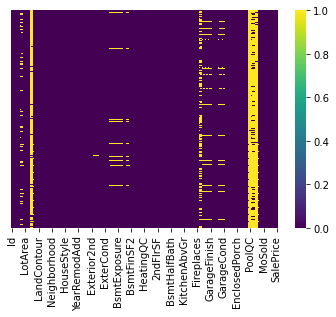

In [8]:
sns.heatmap(train.isnull(),yticklabels=False, cmap='viridis')

In [9]:
train.dropna(subset=['SalePrice'],axis=0,inplace=True)

In [10]:
X=train.copy()
y=X.pop('SalePrice')
model=RandomForestRegressor(n_estimators=100,random_state=0)

def MAE_calculation(X,y,model):
    "Step-1 Replacement of NaN"
    from sklearn.compose import ColumnTransformer
    column_trans = ColumnTransformer(
        [(X.select_dtypes(['float64','int64']),SimpleImputer(strategy='most_frequent')),
         (X.select_dtypes(['object']), SimpleImputer(strategy='most_frequent'))],
        remainder='passthrough')
    
    "Step-2*** Factorization of categorical columns"
    for colname in X.select_dtypes(["category", "object"]):
        X[colname],_ = X[colname].factorize()
        
    "Step-3*** Train test & split"
    train_X, val_X, train_y, val_y = train_test_split(X,y,train_size=0.8,test_size=0.2,random_state=0)
    
    "Step-4*** Final Step of error calculation "
    model.fit(train_X,train_y)
    
    #scores =cross_val_score(model.predict(X),y, cv=3, scoring='mean_absolute_error')
    
    print("MAE is:",mean_absolute_error(model.predict(val_X),val_y))

In [11]:
X.drop(columns=['LotFrontage','MasVnrArea','GarageYrBlt'],inplace=True)
MAE_calculation(X,y,model)

MAE is: 17581.744075342463


In [12]:
MAE_calculation(X,y,model=KNeighborsRegressor())

MAE is: 30927.228767123284


In [13]:
discrete_features = X.dtypes == int

from sklearn.feature_selection import mutual_info_regression

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores[::10] 

OverallQual      0.531759
TotalBsmtSF      0.247109
BsmtFinSF1       0.124348
CentralAir       0.069351
WoodDeckSF       0.049309
EnclosedPorch    0.026607
3SsnPorch        0.008549
PoolArea         0.000000
Name: MI Scores, dtype: float64

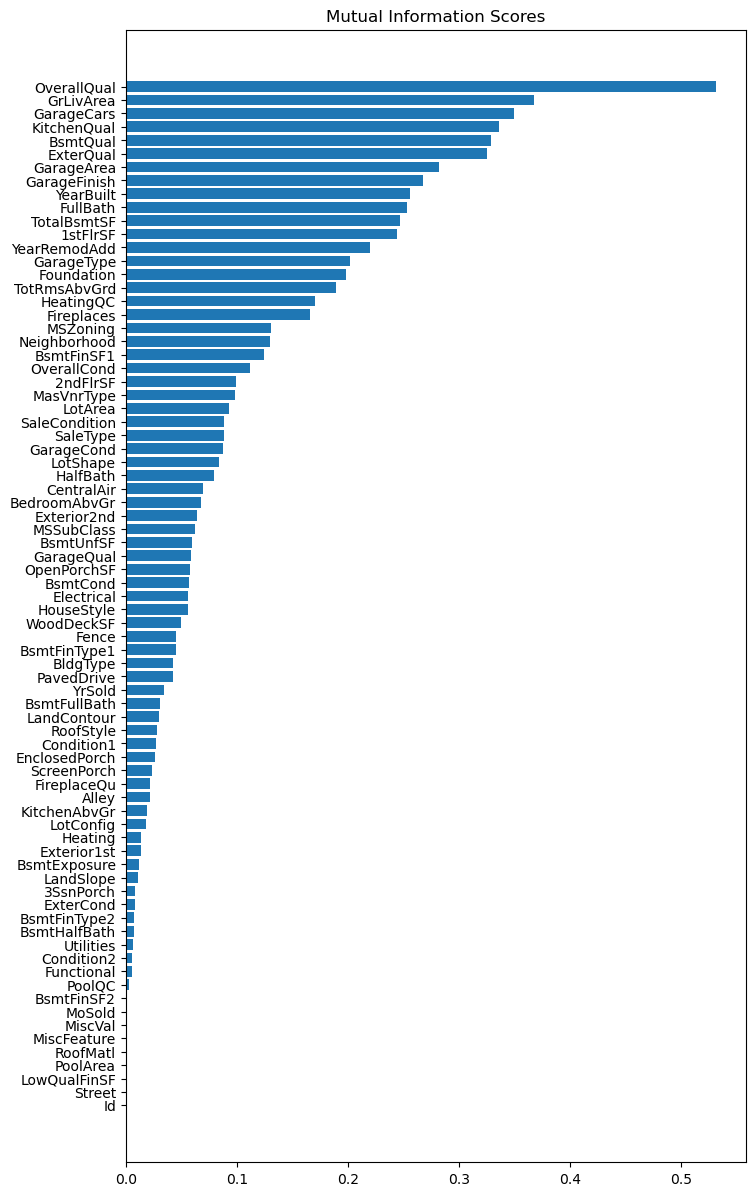

In [14]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 15))
plot_mi_scores(mi_scores)

In [15]:
def compare_object_columns(train,test):
    l=train.select_dtypes(include='object').columns.tolist()
    for i in l:
        Tr=train[i].unique().tolist()
        Te=test[i].unique().tolist()
        if set(train[i].unique())!=set(test[i].unique()):
            Tr=["nan" if x is np.nan else x for x in Tr]
            print ('**** train:',i,sorted(set(Tr)),end='\n')
            Te=["nan" if x is np.nan else x for x in Te]
            print ('#### test:',i,sorted(set(Te)),end='\n''\n')

In [16]:
compare_object_columns(train,test)

**** train: Utilities ['AllPub', 'NoSeWa']
#### test: Utilities ['AllPub']

**** train: Condition2 ['Artery', 'Feedr', 'Norm', 'PosA', 'PosN', 'RRAe', 'RRAn', 'RRNn']
#### test: Condition2 ['Artery', 'Feedr', 'Norm', 'PosA', 'PosN']

**** train: HouseStyle ['1.5Fin', '1.5Unf', '1Story', '2.5Fin', '2.5Unf', '2Story', 'SFoyer', 'SLvl']
#### test: HouseStyle ['1.5Fin', '1.5Unf', '1Story', '2.5Unf', '2Story', 'SFoyer', 'SLvl']

**** train: RoofMatl ['ClyTile', 'CompShg', 'Membran', 'Metal', 'Roll', 'Tar&Grv', 'WdShake', 'WdShngl']
#### test: RoofMatl ['CompShg', 'Tar&Grv', 'WdShake', 'WdShngl']

**** train: Exterior1st ['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd', 'HdBoard', 'ImStucc', 'MetalSd', 'Plywood', 'Stone', 'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing']
#### test: Exterior1st ['AsbShng', 'AsphShn', 'BrkComm', 'BrkFace', 'CBlock', 'CemntBd', 'HdBoard', 'MetalSd', 'Plywood', 'Stucco', 'VinylSd', 'Wd Sdng', 'WdShing']

**** train: Exterior2nd ['AsbShng', 'AsphShn', 'B

In [17]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [18]:
len(train)

1460

In [19]:
for cols in train.select_dtypes(include='object'):
    if set(train[cols].unique())!=set(test[cols].unique()):
        print ('**',cols,'**','\n','\n',train.groupby(cols)[cols].agg('count'),'**/n**')
    

** Utilities ** 
 
 Utilities
AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64 **/n**
** Condition2 ** 
 
 Condition2
Artery       2
Feedr        6
Norm      1445
PosA         1
PosN         2
RRAe         1
RRAn         1
RRNn         2
Name: Condition2, dtype: int64 **/n**
** HouseStyle ** 
 
 HouseStyle
1.5Fin    154
1.5Unf     14
1Story    726
2.5Fin      8
2.5Unf     11
2Story    445
SFoyer     37
SLvl       65
Name: HouseStyle, dtype: int64 **/n**
** RoofMatl ** 
 
 RoofMatl
ClyTile       1
CompShg    1434
Membran       1
Metal         1
Roll          1
Tar&Grv      11
WdShake       5
WdShngl       6
Name: RoofMatl, dtype: int64 **/n**
** Exterior1st ** 
 
 Exterior1st
AsbShng     20
AsphShn      1
BrkComm      2
BrkFace     50
CBlock       1
CemntBd     61
HdBoard    222
ImStucc      1
MetalSd    220
Plywood    108
Stone        2
Stucco      25
VinylSd    515
Wd Sdng    206
WdShing     26
Name: Exterior1st, dtype: int64 **/n**
** Exterior2nd ** 
 
 Exterior2nd
AsbShng

In [20]:
"from above two studies we see that MiscFeature: TenC=1, PoolQC: Fa=2, GarageQual: Ex=3, Eelctrical: Mix=1, Heating: Floor &" 
"OthW are 1 & 2, Exterior2nd: Other=1, Exterior1st: Imstucc & Stone 1 & 2, RoomMatl: ClyTile=1, Membran=1, Metal=1 & Roll=1"
"HouseStyle 2.5Fin=8, Condition2:RRAe=1, RRAn=1, RRNn=2, Utilities: NoSeWa=1 // In short these are in very small qty. Hence"
"Hence we are dropping all these rows from train dataset. Point to be noted that these are not there in test dataset also"

'Hence we are dropping all these rows from train dataset. Point to be noted that these are not there in test dataset also'

In [21]:
train1=train[(train.MiscFeature !='TenC') & (train.PoolQC !='Fa') & (train.GarageQual !='Ex') 
              & (train.Electrical !='Mix') & (train.Heating.isin(['Floor','OthW'])==False) & 
             (train.Exterior1st.isin(['ImStucc','Stone'])==False)
             & (train.Exterior2nd !='Other') & (train.RoofMatl.isin(['ClyTile','Membran','Metal','Roll'])==False)
             & (train.HouseStyle !='2.5Fin') & (train.Condition2.isin(['RRAe','RRAn','RRNn'])==False) & (train.Utilities !='NoSeWa')]

In [22]:
train1.shape

(1431, 81)

In [23]:
train1.BedroomAbvGr.unique()

array([3, 4, 1, 2, 0, 5, 6], dtype=int64)

In [24]:
"Exploring the 0 bedroom sizes: which clearly does not make any sense"

train[train.BedroomAbvGr==0].shape

"So we have 6 such cases, which we are dropping"

train2=train1[(train1.BedroomAbvGr!=0)]


In [25]:
train2.shape

(1425, 81)

In [26]:
"Let us explore the construction area , sales price and bedroom size"

'Let us explore the construction area , sales price and bedroom size'

In [27]:
train2.loc[:,('LotArea','BsmtUnfSF','TotalBsmtSF','1stFlrSF', '2ndFlrSF','GarageArea','GrLivArea','WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch','3SsnPorch', 'ScreenPorch', 'PoolArea')]

,LotArea,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,GarageArea,GrLivArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea
0,8450,150,856,856,854,548,1710,0,61,0,0,0,0
1,9600,284,1262,1262,0,460,1262,298,0,0,0,0,0
2,11250,434,920,920,866,608,1786,0,42,0,0,0,0
3,9550,540,756,961,756,642,1717,0,35,272,0,0,0
4,14260,490,1145,1145,1053,836,2198,192,84,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,7917,953,953,953,694,460,1647,0,40,0,0,0,0
1456,13175,589,1542,2073,0,500,2073,349,0,0,0,0,0
1457,9042,877,1152,1188,1152,252,2340,0,60,0,0,0,0
1458,9717,0,1078,1078,0,240,1078,366,0,112,0,0,0


In [28]:
train2['Total_SF']=train2[['TotalBsmtSF','1stFlrSF', '2ndFlrSF','GarageArea','GrLivArea','WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch','3SsnPorch', 'ScreenPorch', 'PoolArea']].sum(axis=1)

test['Total_SF']=test[['TotalBsmtSF','1stFlrSF', '2ndFlrSF','GarageArea','GrLivArea','WoodDeckSF', 'OpenPorchSF',
       'EnclosedPorch','3SsnPorch', 'ScreenPorch', 'PoolArea']].sum(axis=1)

test2=test.copy()

<ipython-input-28-c597774ff537>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train2['Total_SF']=train2[['TotalBsmtSF','1stFlrSF', '2ndFlrSF','GarageArea','GrLivArea','WoodDeckSF', 'OpenPorchSF',


In [29]:
train2['Per_SF_Rate']=(train2['SalePrice']/train2['Total_SF']).round(0)

<ipython-input-29-50474fa49e00>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train2['Per_SF_Rate']=(train2['SalePrice']/train2['Total_SF']).round(0)


In [30]:
train2.head(2)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,Total_SF,Per_SF_Rate
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,2,2008,WD,Normal,208500,4885,43.0
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,NaN,NaN,0,5,2007,WD,Normal,181500,4544,40.0


In [31]:
train.loc[:,('PoolQC','PoolArea')]

,PoolQC,PoolArea
0,NaN,0
1,NaN,0
2,NaN,0
3,NaN,0
4,NaN,0
...,...,...
1455,NaN,0
1456,NaN,0
1457,NaN,0
1458,NaN,0


In [32]:
test.groupby('PoolQC')['PoolQC'].agg('count')

PoolQC
Ex    2
Gd    1
Name: PoolQC, dtype: int64

In [33]:
test.groupby('PoolArea')['PoolArea'].agg('count')

PoolArea
0      1453
144       1
228       1
368       1
444       1
561       1
800       1
Name: PoolArea, dtype: int64

In [34]:
"Pool QC data points are very low; we also see that these are very low in test data set also. Hence we are dropping PoolQC & PoolArea"

'Pool QC data points are very low; we also see that these are very low in test data set also. Hence we are dropping PoolQC & PoolArea'

In [35]:
train3=train2.drop(['PoolQC','PoolArea'],axis=1)
test3=test2.drop(['PoolQC','PoolArea'],axis=1)

In [36]:
train3.groupby('BedroomAbvGr')['BedroomAbvGr'].agg('count')

BedroomAbvGr
1     48
2    349
3    797
4    207
5     17
6      7
Name: BedroomAbvGr, dtype: int64

In [37]:
train3.BedroomAbvGr.unique()

array([3, 4, 1, 2, 5, 6], dtype=int64)

In [38]:
train3[train3.BedroomAbvGr==1].Total_SF.describe()

count      48.000000
mean     3936.958333
std      1751.935403
min       668.000000
25%      2652.000000
50%      3202.000000
75%      5112.750000
max      7910.000000
Name: Total_SF, dtype: float64

In [39]:
train3[train3.BedroomAbvGr==2].Total_SF.describe()


count     349.000000
mean     3991.736390
std      1243.511997
min      1728.000000
25%      3046.000000
50%      3742.000000
75%      4763.000000
max      9157.000000
Name: Total_SF, dtype: float64

In [40]:
train3[train3.BedroomAbvGr==3].Total_SF.describe()

count      797.000000
mean      4708.582183
std       1183.275882
min       2058.000000
25%       3859.000000
50%       4525.000000
75%       5406.000000
max      13988.000000
Name: Total_SF, dtype: float64

In [41]:
train3[train3.BedroomAbvGr==4].Total_SF.describe()

count      207.000000
mean      5958.990338
std       1624.097246
min       2808.000000
25%       4912.500000
50%       5615.000000
75%       6921.000000
max      12965.000000
Name: Total_SF, dtype: float64

In [42]:
train3[train3.BedroomAbvGr==5].Total_SF.describe()

count      17.000000
mean     6340.235294
std      1408.221419
min      3177.000000
25%      5751.000000
50%      6085.000000
75%      7308.000000
max      9078.000000
Name: Total_SF, dtype: float64

In [43]:
train3[train3.BedroomAbvGr==6].Total_SF.describe()

count       7.000000
mean     5654.428571
std       935.575021
min      4396.000000
25%      5281.000000
50%      5688.000000
75%      5725.500000
max      7484.000000
Name: Total_SF, dtype: float64

In [44]:
train3.shape

(1425, 81)

In [45]:
def outlier_removal_Neighborhood_SF_Rate(df):
    df1=pd.DataFrame()
    for key, df2 in df.groupby('Neighborhood'):
        mean=np.mean(df2.Per_SF_Rate)
        std=np.std(df2.Per_SF_Rate)
        df3=df2[(df2.Per_SF_Rate>(mean-2*std)) & (df2.Per_SF_Rate<(mean+2*std))]
        df1=pd.concat([df1,df3],ignore_index=True)
    return df1

In [46]:
train4=outlier_removal_Neighborhood_SF_Rate(train3)

In [47]:
train4.shape

(1352, 81)

In [48]:
def outlier_removal_Bedroom_Total_SF(df):
    df1=pd.DataFrame()
    for key, df2 in df.groupby('BedroomAbvGr'):
        mean=np.mean(df2.Total_SF)
        std=np.std(df2.Total_SF)
        df3=df2[(df2.Total_SF>(mean-2*std)) & (df2.Total_SF<(mean+2*std))]
        df1=pd.concat([df1,df3],ignore_index=True)
    return df1

In [49]:
train5=outlier_removal_Bedroom_Total_SF(train4)

In [50]:
train5.shape

(1293, 81)

LotFrontage , 233 , 18 %
Alley , 1209 , 94 %
MasVnrType , 7 , 1 %
MasVnrArea , 7 , 1 %
BsmtQual , 28 , 2 %
BsmtCond , 28 , 2 %
BsmtExposure , 29 , 2 %
BsmtFinType1 , 28 , 2 %
BsmtFinType2 , 28 , 2 %
Electrical , 1 , 0 %
FireplaceQu , 629 , 49 %
GarageType , 63 , 5 %
GarageYrBlt , 63 , 5 %
GarageFinish , 63 , 5 %
GarageQual , 63 , 5 %
GarageCond , 63 , 5 %
Fence , 1035 , 80 %
MiscFeature , 1247 , 96 %


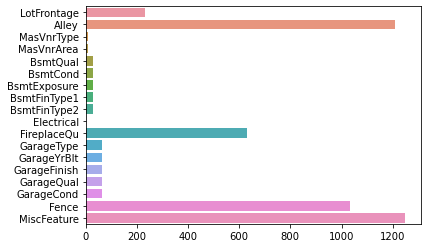

In [51]:
df=train5.copy()
l=df.select_dtypes(include=['object','int64','float64']).columns

results=[]

for i in l:
    sum_na=df[i].isna().sum()
    sum_na += np.sum(df[i] == "nan")
    if sum_na>0:
        print(i,',',str(sum_na),',',round((sum_na/len(df))*100),'%')
        results.append(i)
sns.barplot(y=df[results].isnull().sum().index, x=df[results].isnull().sum().values)
plt.show()

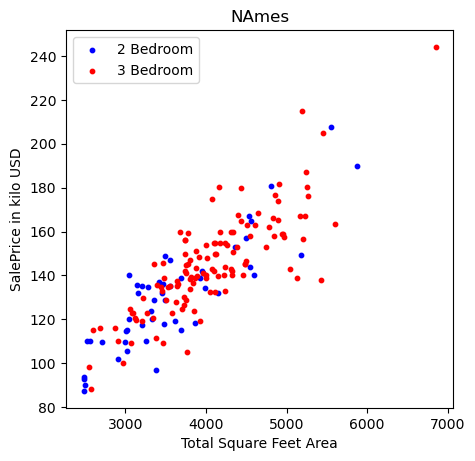

In [52]:
def plot_scatter_chart(df,Neighborhood):
    bed2=df[(df.Neighborhood==Neighborhood) & (df.BedroomAbvGr==2)]
    bed3=df[(df.Neighborhood==Neighborhood) & (df.BedroomAbvGr==3)]
    plt.figure(dpi=100, figsize=(5,5))
    plt.scatter(bed2.Total_SF,bed2.SalePrice/1000,color='blue',label='2 Bedroom', s=10)
    plt.scatter(bed3.Total_SF,bed3.SalePrice/1000,color='red',label='3 Bedroom', s=10)
    plt.xlabel('Total Square Feet Area')
    plt.ylabel('SalePrice in kilo USD')
    plt.title(Neighborhood)
    plt.legend()

plot_scatter_chart(train5,'NAmes')

In [53]:
def remove_Price_Per_SF_outliers(df):
    remove_rows=np.array([])
    for locality, location_df in df.groupby('Neighborhood'):
        bedroom_stat={}
        for bedroom, bedroom_df in df.groupby('BedroomAbvGr'):
            bedroom_stat[bedroom]={
                'mean': np.mean(bedroom_df.Per_SF_Rate),
                'std': np.std(bedroom_df.Per_SF_Rate),
                'count': bedroom_df.shape[0]
            }
        for bedroom, bedroom_df in df.groupby('BedroomAbvGr'):
            stat=bedroom_stat.get(bedroom-1)
            if stat and stat['count']>5:
                remove_rows=np.append(remove_rows, bedroom_df[bedroom_df.Per_SF_Rate<(stat['mean'])].index.values)
    return df.drop(remove_rows,axis='index')

In [54]:
train6=remove_Price_Per_SF_outliers(train5)

In [55]:
train6.shape

(607, 81)

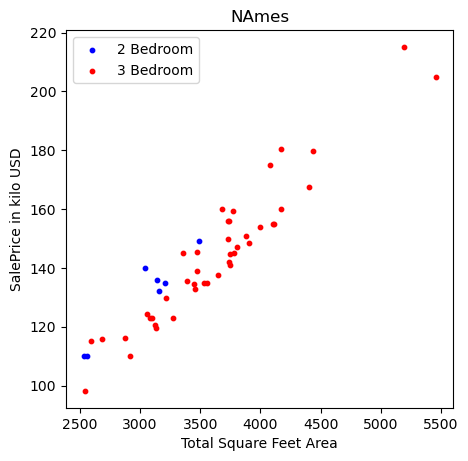

In [56]:
plot_scatter_chart(train6,'NAmes')

Text(0, 0.5, 'Count')

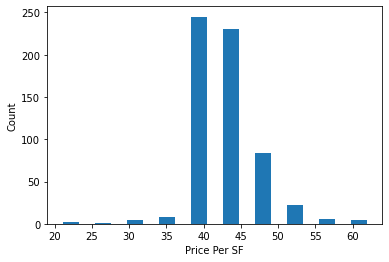

In [57]:
plt.hist(train6.Per_SF_Rate,rwidth=0.5)
plt.xlabel('Price Per SF')
plt.ylabel('Count')

In [58]:
train7=train6.drop(['Per_SF_Rate','MiscFeature','Alley','FireplaceQu','Fence','LotFrontage'],axis=1)
train7.head(2)
test4=test3.drop(['MiscFeature','Alley','FireplaceQu','Fence','LotFrontage'],axis=1)

In [59]:
train7.shape

(607, 75)

In [60]:
#train8=train7.dropna(subset=['GarageType','GarageYrBlt', 'GarageFinish','GarageQual','GarageCond',
#                             'MasVnrType','MasVnrArea','BsmtQual','BsmtCond','BsmtExposure',
#                             'BsmtFinType1','BsmtFinType2','Electrical'],axis=0)
#train8.shape

"We tried by removing the NaNs from rows instaed of dropping these columns, the result from grid search" 
"cv is as mentioned below"



'cv is as mentioned below'

In [61]:
"Insetad of removing the NaNs if we drop the column the result has increased significantly"
"Hence we follow the same approach in test dataset also"

train8=train7.drop(['GarageType','GarageYrBlt', 'GarageFinish','GarageQual','GarageCond',
                             'MasVnrType','MasVnrArea','BsmtQual','BsmtCond','BsmtExposure',
                             'BsmtFinType1','BsmtFinType2','Electrical'],axis=1)
train8.shape

test5=test4.drop(['GarageType','GarageYrBlt', 'GarageFinish','GarageQual','GarageCond',
                             'MasVnrType','MasVnrArea','BsmtQual','BsmtCond','BsmtExposure',
                             'BsmtFinType1','BsmtFinType2','Electrical'],axis=1)
test5.shape

(1459, 61)

In [62]:
train8.shape

(607, 62)

In [63]:
num_cols=test5.select_dtypes(exclude='object')
cat_cols=test5.select_dtypes(include='object')

num_impute=SimpleImputer(strategy='mean')
cat_impute=SimpleImputer(strategy='most_frequent')

num_rev=num_impute.fit_transform(num_cols)
cat_rev=cat_impute.fit_transform(cat_cols)

num_df=pd.DataFrame(num_rev,columns=num_cols.columns)
cat_df=pd.DataFrame(cat_rev,columns=cat_cols.columns)

test6=pd.concat([num_df,cat_df],axis=1)

test6.shape

(1459, 61)

In [64]:
"Model Preparation"

dummy_train=pd.get_dummies(train8.select_dtypes(include='object'))
dummy_train.shape

dummy_test=pd.get_dummies(test5.select_dtypes(include='object'))
dummy_test.shape


(1459, 168)

In [65]:
dummy_train.shape

(607, 144)

In [66]:
categorical_cols=[cols for cols in test5.columns if test5[cols].dtype=='object'  
                 and set(test5[cols]).issubset(set(train8[cols]))] 
len(categorical_cols)

17

In [67]:
#test6.select_dtypes(include='object')

In [68]:
'Neighborhood','Exterior1st','Exterior2nd'
'while we can drop exterior 1st & 2nd we cannot drop neighborhood'

'while we can drop exterior 1st & 2nd we cannot drop neighborhood'

In [69]:
compare_object_columns(train8,test6)

**** train: Neighborhood ['Blmngtn', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker']
#### test: Neighborhood ['Blmngtn', 'Blueste', 'BrDale', 'BrkSide', 'ClearCr', 'CollgCr', 'Crawfor', 'Edwards', 'Gilbert', 'IDOTRR', 'MeadowV', 'Mitchel', 'NAmes', 'NPkVill', 'NWAmes', 'NoRidge', 'NridgHt', 'OldTown', 'SWISU', 'Sawyer', 'SawyerW', 'Somerst', 'StoneBr', 'Timber', 'Veenker']

**** train: Condition2 ['Norm']
#### test: Condition2 ['Artery', 'Feedr', 'Norm', 'PosA', 'PosN']

**** train: RoofStyle ['Flat', 'Gable', 'Gambrel', 'Hip']
#### test: RoofStyle ['Flat', 'Gable', 'Gambrel', 'Hip', 'Mansard', 'Shed']

**** train: RoofMatl ['CompShg', 'Tar&Grv']
#### test: RoofMatl ['CompShg', 'Tar&Grv', 'WdShake', 'WdShngl']

**** train: Exterior1st ['AsbShng', 'BrkFace', 'CemntBd', 'HdBoard', 'MetalSd', 'Plywood', 'Stucco', 'Vi

In [70]:
train9=pd.concat([train8,dummy_train],axis=1)
train9.shape

test6=pd.concat([test5,dummy_test],axis=1)
test6.shape

(1459, 229)

In [71]:
train9.shape

(607, 206)

In [72]:
columns_to_drop_train=train9.select_dtypes(include='object')
train10=train9.drop(columns=columns_to_drop_train,axis=1)
train10.shape

columns_to_drop_test=test6.select_dtypes(include='object')
test7=test6.drop(columns=columns_to_drop_test,axis=1)
test7.shape

(1459, 202)

In [73]:
test7.head(2)

,Id,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1461,20,11622,5,6,1961,1961,468,144,270,...,0,0,0,1,0,0,0,0,1,0
1,1462,20,14267,6,6,1958,1958,923,0,406,...,0,0,0,1,0,0,0,0,1,0


In [74]:
train10.shape

(607, 179)

In [75]:
X=train10.copy()
y=X.pop('SalePrice')

In [76]:
train_X, val_X, train_y, val_y = train_test_split(X,y,train_size=0.8,test_size=0.2,random_state=0)

In [77]:
from sklearn.linear_model import LinearRegression
lm=LinearRegression()
lm.fit(train_X,train_y)
lm.score(val_X,val_y)

0.909620933231518

In [78]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score

cv=ShuffleSplit(n_splits=5,test_size=0.2, random_state=0)

cross_val_score(LinearRegression(),X,y,cv=cv)

array([0.90962093, 0.9299633 , 0.88285503, 0.86964535, 0.90227307])

In [79]:
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

def find_best_model_Gridsearchcv (X,y):
    
    algo={
        'Linear Regression': {
            'model': LinearRegression(),
            'params': {
                'normalize': [True,False]
            }
        },
        'Lasso': {
            'model': Lasso(),
            'params': {
                'alpha': [1,2],
                'selection': ['random','cyclic']
            }
        },
        
        'Decision Tree':{
            'model': DecisionTreeRegressor(),
            'params': {
                'criterion': ['mse','friedman_mse'],
                'splitter': ['best','random']
            }
        },
       'Random Forest':{
            'model': RandomForestRegressor(),
            'params': {
                'criterion': ['mse'],
                'n_estimators': [100]
                
            }
       },
        
        'K Nearest Neighbors':{
            'model': KNeighborsRegressor(),
            'params':{
                'n_neighbors':[5]
            }
        },
        
        'XGBRegressor':{
            'model': XGBRegressor(),
            'params':{
                'n_estimators':[50],
                
            }
        },
    }
    
    scores=[]
    cv=ShuffleSplit(n_splits=5,test_size=0.2,random_state=0)
    for algo_name, config in algo.items():
        gs=GridSearchCV(config['model'],config['params'],cv=cv,return_train_score=False)
        gs.fit(X,y)
        scores.append({
            'model':algo_name,
            'best_score': gs.best_score_,
            'best_params': gs.best_params_
        })
    return pd.DataFrame(scores,columns=['model','best_score','best_params'])

find_best_model_Gridsearchcv (X,y)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43762533423.748505, tolerance: 213996313.83480495
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 45160819738.16799, tolerance: 205647165.35793114
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 32876898289.73716, tolerance: 199916239.36689982
  model = cd_fast.enet_coordinate_descent(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWa

,model,best_score,best_params
0,Linear Regression,0.898872,{'normalize': False}
1,Lasso,0.909673,"{'alpha': 2, 'selection': 'cyclic'}"
2,Decision Tree,0.843593,"{'criterion': 'friedman_mse', 'splitter': 'best'}"
3,Random Forest,0.908276,"{'criterion': 'mse', 'n_estimators': 100}"
4,K Nearest Neighbors,0.779764,{'n_neighbors': 5}
5,XGBRegressor,0.912777,{'n_estimators': 50}


In [80]:
test7.shape

(1459, 202)

In [81]:
train10.shape

(607, 179)

In [82]:
final_train, final_test = X.align(test7, join='left', axis=1, fill_value=0)  # inner join

In [83]:
from sklearn.linear_model import Lasso
lasso=Lasso()
lasso.fit(train_X,train_y)
test_pred=lasso.predict(final_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 43701891453.4954, tolerance: 213996313.83480495
  model = cd_fast.enet_coordinate_descent(


In [84]:
output = pd.DataFrame({'Id': test7.Id,
                       'SalePrice': test_pred})
output.to_csv('Ames_Housing_Submissio_Rev-1,Date-01.12.2022.csv', index=False)

In [85]:
from xgboost import XGBRegressor
xgb=XGBRegressor()
xgb.fit(train_X,train_y)
test_pred_xgb=xgb.predict(final_test)

In [86]:
output = pd.DataFrame({'Id': test7.Id,
                       'SalePrice': test_pred_xgb})
output.to_csv('Ames_Housing_Submissio_Rev-2,Date-01.12.2022.csv', index=False)